In [1]:
!pip install torch torchvision

  Using cached torch-2.7.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
Using cached torch-2.7.1-cp312-cp312-win_amd64.whl (216.1 MB)
Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl (1.7 MB)


In [3]:
!pip install matplotlib scikit-learn


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [01:22<00:00, 120kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 72.1kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:09<00:00, 177kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]



--- Training Simple Feedforward NN ---
Epoch [1/5], Loss: 0.2682, Accuracy: 95.76%
Epoch [2/5], Loss: 0.1147, Accuracy: 96.34%
Epoch [3/5], Loss: 0.0799, Accuracy: 97.03%
Epoch [4/5], Loss: 0.0619, Accuracy: 97.41%
Epoch [5/5], Loss: 0.0509, Accuracy: 97.20%

--- Training CNN Model ---
Epoch [1/5], Loss: 0.1704, Accuracy: 97.88%
Epoch [2/5], Loss: 0.0499, Accuracy: 98.83%
Epoch [3/5], Loss: 0.0338, Accuracy: 98.89%
Epoch [4/5], Loss: 0.0253, Accuracy: 98.95%
Epoch [5/5], Loss: 0.0193, Accuracy: 98.96%


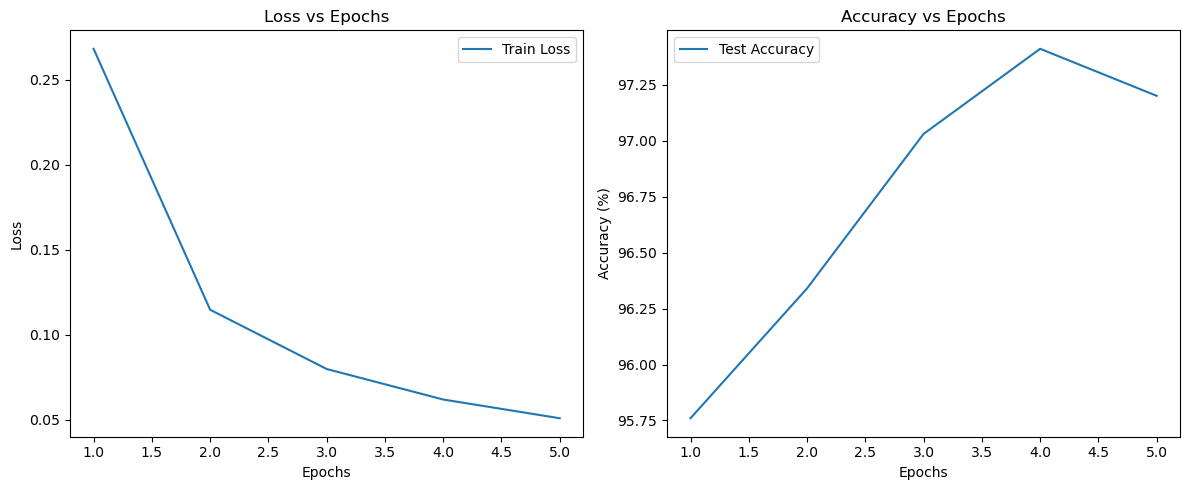

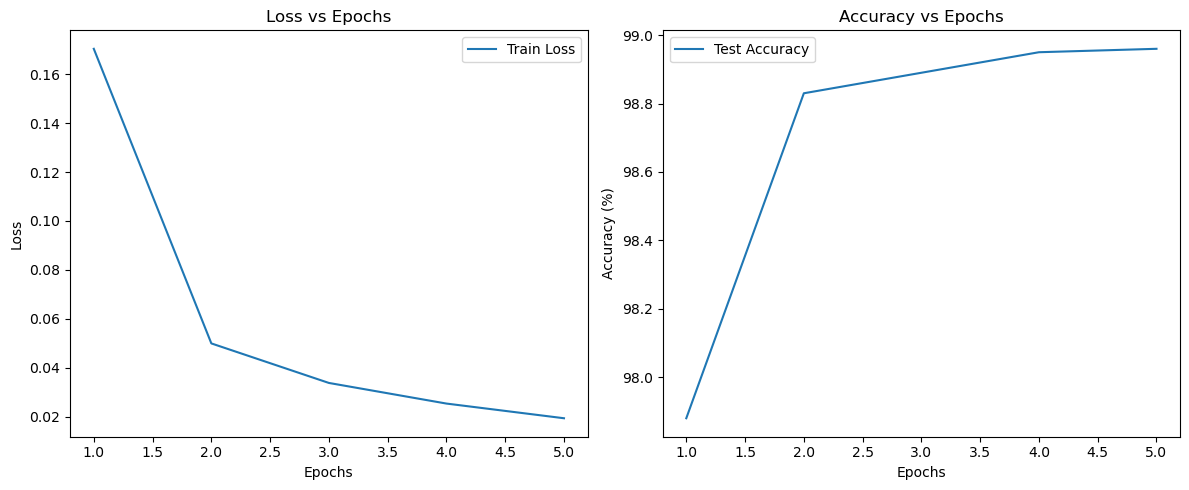

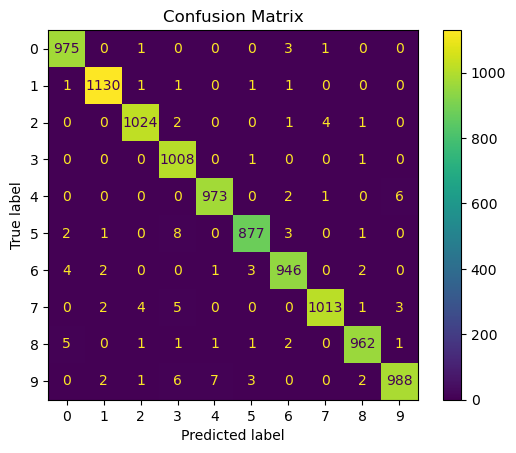

CNN model saved as cnn_mnist.pth


In [12]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.fc(x)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Training
def train_model(model, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        test_accuracies.append(acc)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {acc:.2f}%")

    return train_losses, test_accuracies

# Plotting
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Confusion matrix
def show_confusion_matrix(model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

# Run and compare both models
print("\n--- Training Simple Feedforward NN ---")
nn_model = SimpleNN()
nn_losses, nn_accuracies = train_model(nn_model)

print("\n--- Training CNN Model ---")
cnn_model = CNN()
cnn_losses, cnn_accuracies = train_model(cnn_model)

# Plot
plot_metrics(nn_losses, nn_accuracies)
plot_metrics(cnn_losses, cnn_accuracies)

# Confusion matrix for CNN
show_confusion_matrix(cnn_model)

# Save model
torch.save(cnn_model.state_dict(), 'cnn_mnist.pth')
print("CNN model saved as cnn_mnist.pth")